In [1]:
!nvidia-smi

Thu Jun 27 11:43:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             10W /  285W |     721MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: C:\Users\Utente\Desktop\UR\Code


In [3]:
%cd {HOME}

# install FastSAM
#!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
#!pip -q install -r FastSAM/requirements.txt
# install CLIP
#!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
#!pip -q install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
#!pip -q install roboflow supervision jupyter_bbox_widget




C:\Users\Utente\Desktop\UR\Code


In [4]:
#!mkdir -p {HOME}/weights
#!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
#!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

!ls -lh {HOME}/weights

total 2.6G
-rw-r--r-- 1 Utente 197121 139M May 10 20:15 FastSAM.pt
-rw-r--r-- 1 Utente 197121 2.4G May 10 20:19 sam_vit_h_4b8939.pth


In [5]:
FAST_SAM_CHECKPOINT_PATH = f"{HOME}/weights/FastSAM.pt"
SAM_SAM_CHECKPOINT_PATH = f"{HOME}/weights/sam_vit_h_4b8939.pth"

In [6]:
#!mkdir -p {HOME}/data
#!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
#!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/robot.jpeg
!ls -lh {HOME}/data

total 532K
-rw-r--r-- 1 Utente 197121 104K May 10 20:32 dog.jpeg
-rw-r--r-- 1 Utente 197121 426K May 10 20:32 robot.jpeg


In [7]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.measure import find_contours
from skimage.color import rgb2hsv, rgb2gray

C:\Users\Utente\Desktop\UR\Code\FastSAM


In [8]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

In [9]:
try:
  import google.colab
  colab_env = True
  base_path = '/content/gdrive/MyDrive/'
  from google.colab import runtime
  print('colab_env')
except:
  colab_env = False
  base_path = ''
  print('local_env')

if colab_env:
  from google.colab import drive
  drive.mount('/content/gdrive')
  base_path = '/content/gdrive/MyDrive/'
else:
    base_path = f"{HOME}"


local_env


In [10]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)
    read_mask = detections.mask
    read_class = detections.class_id
    print(read_class)
    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

def iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = torch.logical_or(mask1, mask2).to(torch.int).sum()
    return intersection / union

def area_value(area_element):
  return(area_element[1])

Foto scattata e salvata come 'C:\Users\Utente\Desktop\UR\Code/Dataset/pizza/pizzacut_tmp.jpg'



image 1/1 C:\Users\Utente\Desktop\UR\Code\Dataset\pizza\pizzacut_tmp.jpg: 768x1024 11 objects, 1071.8ms
Speed: 7.1ms preprocess, 1071.8ms inference, 15.6ms postprocess per image at shape (1, 3, 1024, 1024)


None


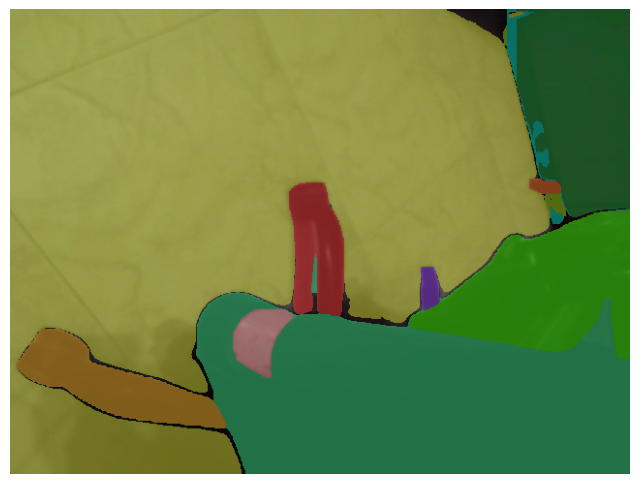

In [11]:
def scatta_foto(percorso_salvataggio):
    # Apri la webcam (la webcam di default ha l'indice 0)
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Errore nell'apertura della webcam")
        return False

    # Leggi un frame dalla webcam
    ret, frame = cap.read()

    if ret:
        # Salva l'immagine catturata nel percorso specificato
        cv2.imwrite(percorso_salvataggio, frame)
        print(f"Foto scattata e salvata come '{percorso_salvataggio}'")
    else:
        print("Errore nella lettura del frame dalla webcam")
        return False


percorso_salvataggio= base_path +"/Dataset/pizza/pizzacut_tmp.jpg"
scatta_foto(percorso_salvataggio)
IMAGE_PATH=percorso_salvataggio

#IMAGE_PATH = base_path + "/Dataset/pizza/pizzacut_4.jpg"
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.4,
    iou=0.9)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()
prompt_process.plot(annotations=masks, output_path=f"{HOME}/output_pizzacut_4.jpeg")


masks_fastsam = masks.cpu().numpy().astype(bool)
annotated_image =annotate_image(image_path=IMAGE_PATH, masks=masks_fastsam)
sv.plot_image(image=annotated_image, size=(8, 8))




Spot ground truth based on grayscale


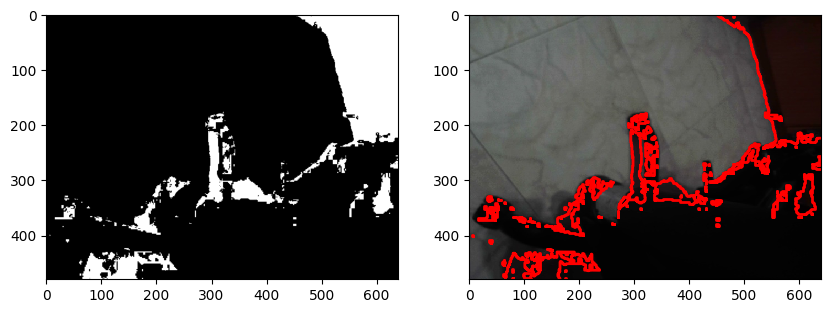

Masks of FastSAM detection


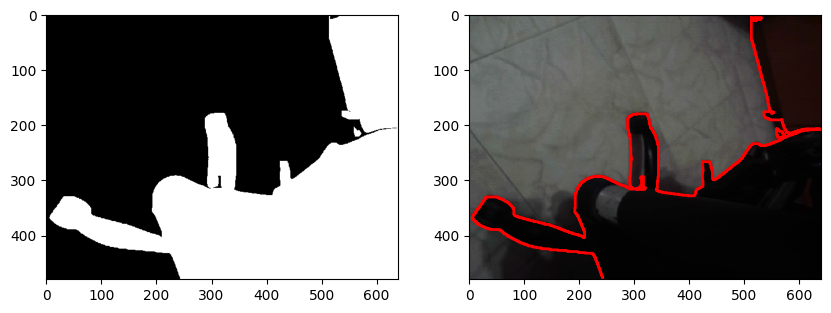

Intersection over union: FastSAM vs grayscale 0.2562445104122162


In [12]:
myimg= imread(IMAGE_PATH)
myimg_hsv = rgb2hsv(myimg)

saturation = myimg_hsv[:,:,1]
binary_image = np.where(saturation > 0.15, 1, 0).astype(np.uint8)

spots = np.where(binary_image > 0)

contours_gray = find_contours(binary_image, 0.8)

# Display the image and plot the contour
print("Spot ground truth based on grayscale")
fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(binary_image, cmap='gray')

#fig, ax = plt.subplots()
ax[1].imshow(myimg, interpolation='nearest')
X, Y = ax[1].get_xlim(), ax[1].get_ylim()
for contour in contours_gray:
    ax[1].step(contour.T[1], contour.T[0], linewidth=2, c='r')
ax[1].set_xlim(X), ax[1].set_ylim(Y)
plt.savefig(f"{HOME}/pizzacut_4_grayscale.png")
plt.show()


final_mask = torch.zeros((masks_fastsam.shape[1],masks_fastsam.shape[2]))
areas = []
count_remove = 0
for i in range(masks_fastsam.shape[0]):
  areas.append([i,np.sum(masks_fastsam[i])])
  if (np.sum(masks_fastsam[i])>masks_fastsam.shape[1]*masks_fastsam.shape[2]/2*0.7): #consider as pizza box detection masks bigger than 70% of the half of the image (if the image is cut around the pizza box)
    count_remove += 1

#imshow(np.array(final_mask), cmap='gray')
#imshow(np.array(masks_fastsam[23]), cmap='gray')
areas.sort(key=area_value)
areas = np.array(areas)
areas = areas.transpose(1,0)
areas_index = areas[0]
#print(masks_fastsam.shape[1]*masks_fastsam.shape[2]/2*0.9)
masks_fastsam = masks_fastsam[areas_index]
if count_remove > 0:
  masks_fastsam = masks_fastsam[:-count_remove]

for i in range(masks_fastsam.shape[0]):
    final_mask = torch.logical_or(final_mask, torch.tensor(masks_fastsam[i]))

print("Masks of FastSAM detection")
fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(np.array(final_mask), cmap='gray')


#contour_list = []
contours = find_contours(np.array(final_mask), 0.8)

myimg= imread(IMAGE_PATH)
#fig, ax = plt.subplots()
ax[1].imshow(myimg, interpolation='nearest')
X, Y = ax[1].get_xlim(), ax[1].get_ylim()
for contour in contours:
    ax[1].step(contour.T[1], contour.T[0], linewidth=2, c='r')
ax[1].set_xlim(X), ax[1].set_ylim(Y)
plt.savefig(f"{HOME}/pizzacut_4_fastsam.png")
plt.show()

# 2 is half box, 7 is the other half 14 is a border

IoU = iou(torch.tensor(final_mask),torch.tensor(binary_image))

print("Intersection over union: FastSAM vs grayscale",IoU.item())

Spot ground truth based on grayscale


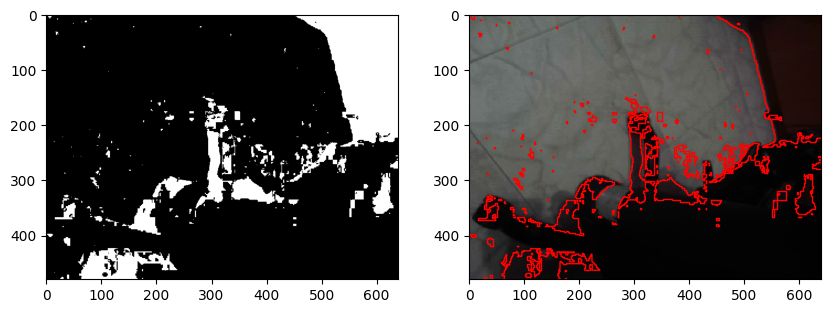

Masks of FastSAM detection
Coordinate del contorno  1 : [[      242.8         479]
 [      242.8         478]
 [      242.8         477]
 ...
 [      512.8           2]
 [      512.8           1]
 [      512.8           0]]
Coordinate del contorno  2 : [[      519.8           8]
 [        520         7.8]
 [        521         7.8]
 [        522         7.8]
 [      522.8           7]
 [        523         6.8]
 [        524         6.8]
 [        525         6.8]
 [        526         6.8]
 [      526.8           6]
 [        527         5.8]
 [        528         5.8]
 [      528.8           5]
 [        529         4.8]
 [        530         4.8]
 [      530.8           4]
 [        530         3.2]
 [      529.8           3]
 [        529         2.2]
 [        528         2.2]
 [        527         2.2]
 [        526         2.2]
 [        525         2.2]
 [        524         2.2]
 [        523         2.2]
 [        522         2.2]
 [        521         2.2]
 [        520     

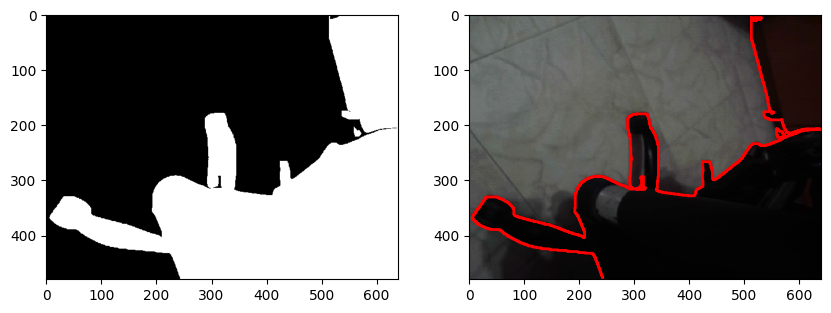

Intersection over union: FastSAM vs grayscale 0.2593904435634613


In [13]:
myimg= imread(IMAGE_PATH)
myimg_hsv = rgb2hsv(myimg)

saturation = myimg_hsv[:,:,1]
binary_image = np.where(saturation > 0.1, 1, 0).astype(np.uint8)#editedf

spots = np.where(binary_image > 0)

contours_gray = find_contours(binary_image, 0.8)

# Display the image and plot the contour
print("Spot ground truth based on grayscale")
fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(binary_image, cmap='gray')

#fig, ax = plt.subplots()
ax[1].imshow(myimg, interpolation='nearest')
X, Y = ax[1].get_xlim(), ax[1].get_ylim()
for contour in contours_gray:
    ax[1].step(contour.T[1], contour.T[0], linewidth=1, c='r')#edit
ax[1].set_xlim(X), ax[1].set_ylim(Y)
plt.savefig(f"{HOME}/pizzacut_4_grayscale.png")
plt.show()


final_mask = torch.zeros((masks_fastsam.shape[1],masks_fastsam.shape[2]))
areas = []
count_remove = 0
for i in range(masks_fastsam.shape[0]):
  areas.append([i,np.sum(masks_fastsam[i])])
  if (np.sum(masks_fastsam[i])>masks_fastsam.shape[1]*masks_fastsam.shape[2]/2*0.7): #consider as pizza box detection masks bigger than 70% of the half of the image (if the image is cut around the pizza box)
    count_remove += 1

#imshow(np.array(final_mask), cmap='gray')
#imshow(np.array(masks_fastsam[23]), cmap='gray')
areas.sort(key=area_value)
areas = np.array(areas)
areas = areas.transpose(1,0)
areas_index = areas[0]
#print(masks_fastsam.shape[1]*masks_fastsam.shape[2]/2*0.9)
masks_fastsam = masks_fastsam[areas_index]
if count_remove > 0:
  masks_fastsam = masks_fastsam[:-count_remove]

for i in range(masks_fastsam.shape[0]):
    final_mask = torch.logical_or(final_mask, torch.tensor(masks_fastsam[i]))

print("Masks of FastSAM detection")
fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(np.array(final_mask), cmap='gray')


#contour_list = []
contours = find_contours(np.array(final_mask), 0.8)

myimg= imread(IMAGE_PATH)
#fig, ax = plt.subplots()
ax[1].imshow(myimg, interpolation='nearest')
X, Y = ax[1].get_xlim(), ax[1].get_ylim()


i=0
for contour in contours:
    i=i+1
    ax[1].step(contour.T[1], contour.T[0], linewidth=2, c='r')
    
    coordinates = contour[:, [1, 0]]  # Scambia colonne per ottenere coordinate (x, y)
    print("Coordinate del contorno ",i,":", coordinates)
    
ax[1].set_xlim(X), ax[1].set_ylim(Y)
plt.savefig(f"{HOME}/pizzacut_4_fastsam.png")
plt.show()

# 2 is half box, 7 is the other half 14 is a border


IoU = iou(torch.tensor(final_mask),torch.tensor(binary_image))

print("Intersection over union: FastSAM vs grayscale",IoU.item())